<a href="https://colab.research.google.com/github/Josh1313/PRUEBA_VISUALCODE/blob/master/3_of_3_STEP_Monday_DPL_of_transf_learning_catsanddogs_basic_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# Connectar a Drive

# En este notebook haremos unos ajustes al notebook que lo entrenamos con perros y gatos borraremos el preprocesamiento y nos quedaremos con el modelo y congelaremos el proceso y cargaremos nuevos datos para que predica mejor,FINE TUNNING + DATA AUGMENTATION.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias

In [3]:
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

# Variables de entorno

<font color="#FF0000">Aquí definireis vuestra ruta del proyecto de perros y Gatos</font>

In [4]:
ANCHO_IMAGEN = 150
ALTURA_IMAGEN=150
IMAGE_SIZE = (ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES = 3

ruta_archivos = '/content/drive/MyDrive/DPL456/'

# Cargaremos datos en NPZ


In [5]:
dict_npz = np.load(ruta_archivos+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

In [6]:
x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [7]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

# Montamos la Red Neuronal

## Cargar la parte de extraccion de features de VGG16

In [8]:
# Creemos una red que será extracción de features basada en VGG16 entrenada con ImageNet

In [9]:
model_vgg16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))# Son los pixeles de las imagenes (features)
# include_top=false, es para agarrar la parte que necesitamos solo el preprocesamiento
model_vgg16.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

Desde aca le extraemos la ultima capa del modelo y se la asiganmos a una variable despues a esa variable le asignamos la funcion flatten para que aplane la salida que es el output del modelo

In [10]:
output = model_vgg16.layers[-1].output  # en este paso  nos quedamos  y lo juntamos
output

<KerasTensor: shape=(None, 4, 4, 512) dtype=float32 (created by layer 'block5_pool')>

In [11]:
output_layer = ks.layers.Flatten()(output)
output_layer

<KerasTensor: shape=(None, 8192) dtype=float32 (created by layer 'flatten')>

In [12]:
model_prevgg16 = Model(model_vgg16.input, output_layer)
model_prevgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
# Veamos como va lo de "congelar" capas de entrenamiento

In [36]:
pd.set_option("display.max_colwidth", True)
layers = [(layer, layer.name, layer.trainable) for layer in model_prevgg16.layers]
pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

,Layer,Name,Is Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7ff3eff37c10>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff3eff37eb0>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e898310>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff30e899510>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e899f90>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e89add0>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff30e89be50>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e89a4d0>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e8992d0>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e89a7a0>,block3_conv3,False


In [37]:
model_prevgg16.trainable

True

In [38]:
# Despues del bloque 4 de convulciones lo haremos true lo demas lo congelaremos y los pondremos false no harana nada

In [39]:
trainable = False
for layer in model_prevgg16.layers:
  if layer.name == "block4_conv1":
    trainable = True

  layer.trainable = trainable


In [40]:
layers = [(layer, layer.name, layer.trainable) for layer in model_prevgg16.layers]
pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

,Layer,Name,Is Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7ff3eff37c10>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff3eff37eb0>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e898310>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff30e899510>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e899f90>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e89add0>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff30e89be50>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e89a4d0>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e8992d0>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff30e89a7a0>,block3_conv3,False


In [41]:
model_prevgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# Montemos la red de clasificación

In [42]:
model_post_vgg = ks.Sequential()

model_post_vgg.add(model_prevgg16)
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(1, activation='sigmoid'))

model_post_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 17,437,185


# Creamos un optimizador

In [43]:
from tensorflow.keras.optimizers import Adam

In [44]:
# ACA LE MODIFICAMOS UN CERO MAS YA QUE NO ENTRENABA NADA !

In [45]:
new_adam = Adam(learning_rate=0.00005)


In [46]:
model_post_vgg.compile(loss='binary_crossentropy', optimizer=new_adam, metrics=['accuracy'])

# Early stopping!!

In [47]:
callback = EarlyStopping(monitor='val_loss', patience=5)

# Encoding de etiquetas

In [48]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [49]:
print(np.array(y_train_img))
print(np.array(y_train_encoded))

y_train_encoded

['cat' 'cat' 'cat' ... 'dog' 'dog' 'dog']
[0 0 0 ... 1 1 1]


array([0, 0, 0, ..., 1, 1, 1])

Desde aca se ase la modificacion que se le incorporara la data augmentation del segundo notebook

# Data generator para data augmentation

In [50]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [51]:
train_datagen = ImageDataGenerator(
    rescale=1./255,

    # Definamos las transformaciones
    rotation_range=15,
    brightness_range=(0.7,1.15),
    horizontal_flip = True,
    zoom_range = 0.5
    # samplewise_std_normalization=True,
    # channel_shift_range = 3.0
    )

train_generator = train_datagen.flow(
    x_train_img,  # Aquí hay que usar datos NO re-escalados... de ahi que no usemos x_train_rescaled!
    y_train_encoded,
    batch_size=30
)

In [52]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img,
    y_val_encoded,
    batch_size=20
)

# Entrenar/ se actualiza el siguiente paso

In [53]:
history = model_post_vgg.fit(train_generator,
                    epochs=200,
                    validation_data=validation_generator,
                    callbacks=[callback],
                    steps_per_epoch =  167, # num_imagenes / batch size = 5000/30 = 166.6667
                    validation_steps = 50 # num_img_val / batch_size = 1000 / 20 = 50
)

Epoch 1/200
167/167 [==============================] - 47s 253ms/step - loss: 0.1114 - accuracy: 0.9530 - val_loss: 0.1440 - val_accuracy: 0.9560
Epoch 2/200
167/167 [==============================] - 42s 252ms/step - loss: 0.0795 - accuracy: 0.9720 - val_loss: 0.1111 - val_accuracy: 0.9590
Epoch 3/200
167/167 [==============================] - 42s 252ms/step - loss: 0.0757 - accuracy: 0.9724 - val_loss: 0.1002 - val_accuracy: 0.9700
Epoch 4/200
167/167 [==============================] - 40s 239ms/step - loss: 0.0793 - accuracy: 0.9710 - val_loss: 0.1375 - val_accuracy: 0.9550
Epoch 5/200
167/167 [==============================] - 43s 255ms/step - loss: 0.0648 - accuracy: 0.9766 - val_loss: 0.1218 - val_accuracy: 0.9570
Epoch 6/200
167/167 [==============================] - 43s 254ms/step - loss: 0.0498 - accuracy: 0.9810 - val_loss: 0.1758 - val_accuracy: 0.9520
Epoch 7/200
167/167 [==============================] - 43s 256ms/step - loss: 0.0600 - accuracy: 0.9784 - val_loss: 0.1588 -

# Guardamos el modelo

Aquí tenemos que guardar el modelo simple, pero tambien hemos de guardar, o bien el modelo de preproceso o bien los datos de test procesados en NPZ...

In [54]:
 #Modelo post VGG16
model_post_vgg.save(ruta_archivos+'model_with_basic_transfer_learning_post_vgg16.h5')



# Miremos que tal rinde el modelo en errores y accuracy

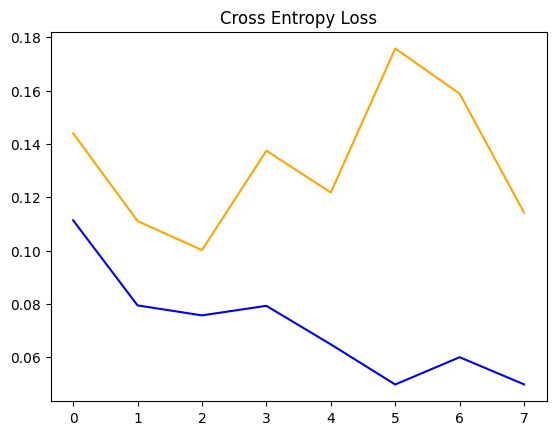

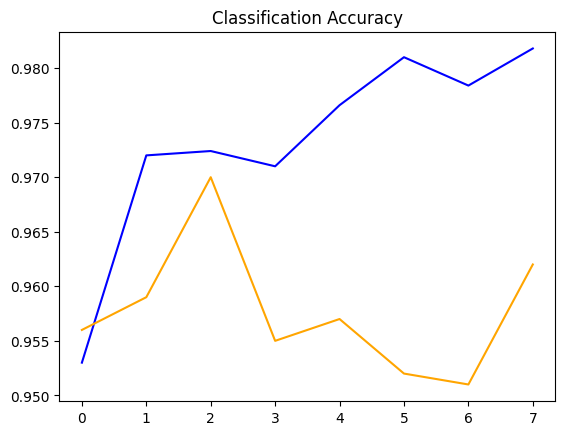

In [55]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [56]:
_, acc = model_post_vgg.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Modelo con Basic Transfer Learning > %.3f' % (acc * 100.0))


Modelo con Basic Transfer Learning > 97.400
